# Import libraries and data

In [1]:
# Import Libraries
suppressPackageStartupMessages({

library(tidyverse)  # Collection of packages including dplyr, ggplot2
library(snakecase)  # Converts strings to snake_case format
library(lubridate)  # Simplifies date and time handling
library(naniar)     # Tools for exploring and handling missing data
library(janitor)    # Data cleaning and examination functions
library(caret)      # Machine learning training and evaluation
library(lightgbm)   # Gradient boosting 
    
})

In [2]:
# Import data 
train <- read_csv("/kaggle/input/playground-series-s4e12/train.csv")
test <- read_csv("/kaggle/input/playground-series-s4e12/test.csv")

Rows: 1200000 Columns: 21


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Gender, Marital Status, Education Level, Occupation, Location, Po...
dbl  (10): id, Age, Annual Income, Number of Dependents, Health Score, Previ...
dttm  (1): Policy Start Date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 800000 Columns: 20


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): Gender, Marital Status, Education Level, Occupation, Location, Po...
dbl   (9): id, Age, Annual Income, Number of Dependents, Health Score, Previ...
dttm  (1): Policy Start Date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Explore and clean data

In [3]:
# Inspect train set
summary(train)

# Print the first few rows 
head(train)

       id               Age           Gender          Annual Income   
 Min.   :      0   Min.   :18.00   Length:1200000     Min.   :     1  
 1st Qu.: 300000   1st Qu.:30.00   Class :character   1st Qu.:  8001  
 Median : 600000   Median :41.00   Mode  :character   Median : 23911  
 Mean   : 600000   Mean   :41.15                      Mean   : 32745  
 3rd Qu.: 899999   3rd Qu.:53.00                      3rd Qu.: 44634  
 Max.   :1199999   Max.   :64.00                      Max.   :149997  
                   NA's   :18705                      NA's   :44949   
 Marital Status     Number of Dependents Education Level     Occupation       
 Length:1200000     Min.   :0.00         Length:1200000     Length:1200000    
 Class :character   1st Qu.:1.00         Class :character   Class :character  
 Mode  :character   Median :2.00         Mode  :character   Mode  :character  
                    Mean   :2.01                                              
                    3rd Qu.:3.00     

id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,⋯,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dbl>
0,19,Female,10049,Married,1,Bachelor's,Self-Employed,22.59876,Urban,⋯,2,17,372,5,2023-12-23 15:21:39,Poor,No,Weekly,House,2869
1,39,Female,31678,Divorced,3,Master's,NA,15.56973,Rural,⋯,1,12,694,2,2023-06-12 15:21:39,Average,Yes,Monthly,House,1483
2,23,Male,25602,Divorced,3,High School,Self-Employed,47.17755,Suburban,⋯,1,14,NA,3,2023-09-30 15:21:39,Good,Yes,Weekly,House,567
3,21,Male,141855,Married,2,Bachelor's,NA,10.93814,Rural,⋯,1,0,367,1,2024-06-12 15:21:39,Poor,Yes,Daily,Apartment,765
4,21,Male,39651,Single,1,Bachelor's,Self-Employed,20.37609,Rural,⋯,0,8,598,4,2021-12-01 15:21:39,Poor,Yes,Weekly,House,2022
5,29,Male,45963,Married,1,Bachelor's,NA,33.05320,Urban,⋯,2,4,614,5,2022-05-20 15:21:39,Average,No,Weekly,House,3202


In [4]:
# Inspect test set
summary(test)

# Print the first few rows
head(test)

       id               Age           Gender          Annual Income   
 Min.   :1200000   Min.   :18.00   Length:800000      Min.   :     2  
 1st Qu.:1400000   1st Qu.:30.00   Class :character   1st Qu.:  8048  
 Median :1600000   Median :41.00   Mode  :character   Median : 23981  
 Mean   :1600000   Mean   :41.14                      Mean   : 32804  
 3rd Qu.:1799999   3rd Qu.:53.00                      3rd Qu.: 44660  
 Max.   :1999999   Max.   :64.00                      Max.   :149997  
                   NA's   :12489                      NA's   :29860   
 Marital Status     Number of Dependents Education Level     Occupation       
 Length:800000      Min.   :0.00         Length:800000      Length:800000     
 Class :character   1st Qu.:1.00         Class :character   Class :character  
 Mode  :character   Median :2.00         Mode  :character   Mode  :character  
                    Mean   :2.01                                              
                    3rd Qu.:3.00     

id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>
1200000,28,Female,2310,NA,4,Bachelor's,Self-Employed,7.657981,Rural,Basic,NA,19,NA,1,2023-06-04 15:21:39,Poor,Yes,Weekly,House
1200001,31,Female,126031,Married,2,Master's,Self-Employed,13.381379,Suburban,Premium,NA,14,372,8,2024-04-22 15:21:39,Good,Yes,Rarely,Apartment
1200002,47,Female,17092,Divorced,0,PhD,Unemployed,24.354527,Urban,Comprehensive,NA,16,819,9,2023-04-05 15:21:39,Average,Yes,Monthly,Condo
1200003,28,Female,30424,Divorced,3,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1,3,770,5,2023-10-25 15:21:39,Poor,Yes,Daily,House
1200004,24,Male,10863,Divorced,2,High School,Unemployed,11.844155,Suburban,Premium,NA,14,755,7,2021-11-26 15:21:39,Average,No,Weekly,House
1200005,43,Male,52370,Married,2,Bachelor's,NA,5.386224,Suburban,Basic,NA,15,432,2,2022-07-08 15:21:39,NA,No,Rarely,Condo


In [5]:
# Function to clean and transform dataframe
clean_and_transform <- function(df) {
  # Convert column names to snake_case
  df <- clean_names(df)
  
  # Clean apostrophes and convert to snake_case
  df$education_level <- gsub("'", "", df$education_level)
  df$education_level <- snakecase::to_snake_case(df$education_level)
  df$occupation <- snakecase::to_snake_case(df$occupation)
  
  return(df)
}

# Apply transformations to train dataframe
train <- clean_and_transform(train)

# Apply transformations to test dataframe
test <- clean_and_transform(test)


In [6]:
# VIZ??

In [7]:
# List of numerical and categorical columns
numerical_cols <- c("age", "annual_income", "health_score", "vehicle_age", 
                    "credit_score", "insurance_duration", "number_of_dependents", "previous_claims")
categorical_cols <- c("gender", "marital_status", "education_level", "occupation", 
                      "location", "policy_type", "customer_feedback", "smoking_status", 
                      "exercise_frequency", "property_type")

# Impute numerical columns with mean
for (col in numerical_cols) {
  mean_value <- mean(train[[col]], na.rm = TRUE)
  train[[col]][is.na(train[[col]])] <- mean_value
  test[[col]][is.na(test[[col]])] <- mean_value
}

# Replace missing values in categorical columns with 'unknown' and convert to factors
for (col in categorical_cols) {
  train[[col]][is.na(train[[col]])] <- "unknown"
  test[[col]][is.na(test[[col]])] <- "unknown"
  
  # Convert to factor
  train[[col]] <- factor(train[[col]])
  test[[col]] <- factor(test[[col]])
}

# Impute datetime column with the median date
median_date <- median(as.POSIXct(train$policy_start_date, format = "%Y-%m-%d %H:%M:%S"), na.rm = TRUE)
train$policy_start_date[is.na(train$policy_start_date)] <- as.character(median_date)
test$policy_start_date[is.na(test$policy_start_date)] <- as.character(median_date)

# Verify no missing values remain
colSums(is.na(train))
colSums(is.na(test))

# Verify that categorical columns are now factors
sapply(train[categorical_cols], is.factor)
sapply(test[categorical_cols], is.factor)


id                  age               gender 
                   0                    0                    0 
       annual_income       marital_status number_of_dependents 
                   0                    0                    0 
     education_level           occupation         health_score 
                   0                    0                    0 
            location          policy_type      previous_claims 
                   0                    0                    0 
         vehicle_age         credit_score   insurance_duration 
                   0                    0                    0 
   policy_start_date    customer_feedback       smoking_status 
                   0                    0                    0 
  exercise_frequency        property_type       premium_amount 
                   0                    0                    0

id                  age               gender 
                   0                    0                    0 
       annual_income       marital_status number_of_dependents 
                   0                    0                    0 
     education_level           occupation         health_score 
                   0                    0                    0 
            location          policy_type      previous_claims 
                   0                    0                    0 
         vehicle_age         credit_score   insurance_duration 
                   0                    0                    0 
   policy_start_date    customer_feedback       smoking_status 
                   0                    0                    0 
  exercise_frequency        property_type 
                   0                    0

gender     marital_status    education_level         occupation 
              TRUE               TRUE               TRUE               TRUE 
          location        policy_type  customer_feedback     smoking_status 
              TRUE               TRUE               TRUE               TRUE 
exercise_frequency      property_type 
              TRUE               TRUE

gender     marital_status    education_level         occupation 
              TRUE               TRUE               TRUE               TRUE 
          location        policy_type  customer_feedback     smoking_status 
              TRUE               TRUE               TRUE               TRUE 
exercise_frequency      property_type 
              TRUE               TRUE

Warning message:
“Unknown or uninitialised column: `premium_amount`.”


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.996   6.242   6.771   6.591   7.319   8.517 

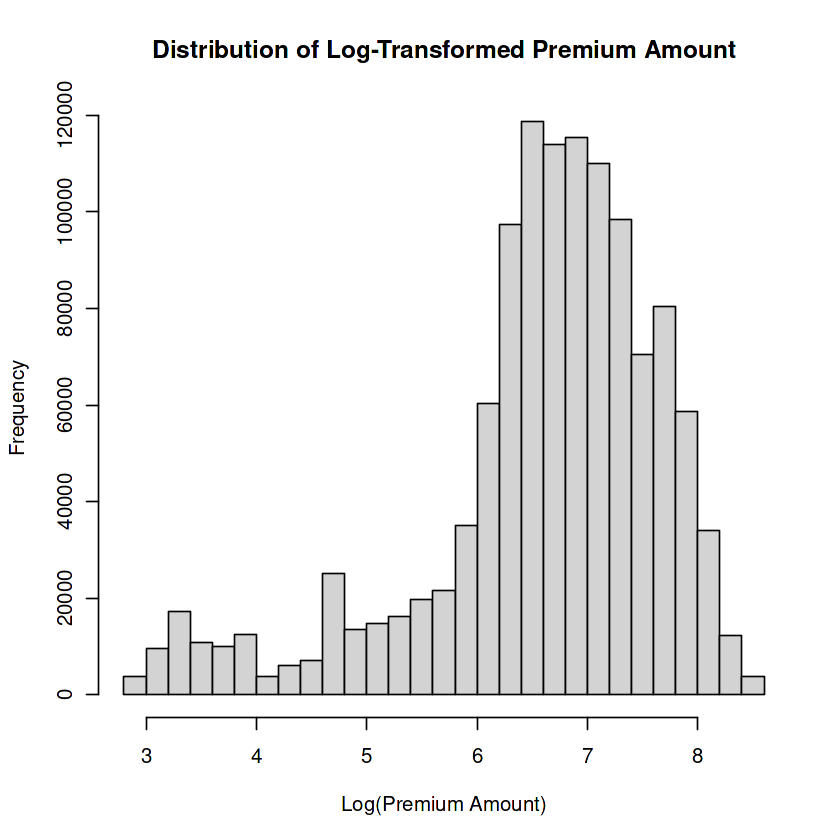

In [8]:
# Check for non-positive values
if (any(train$premium_amount <= 0, na.rm = TRUE) || any(test$premium_amount <= 0, na.rm = TRUE)) {
  # Add a small constant if there are zeros or negative values
  train$premium_amount <- log(train$premium_amount + 1)
} else {
  # If all values are positive, use simple log transformation
  train$premium_amount <- log(train$premium_amount)
}

# Verify the transformation
summary(train$premium_amount)

# Optionally, plot the distribution of the transformed variable
hist(train$premium_amount, main = "Distribution of Log-Transformed Premium Amount", xlab = "Log(Premium Amount)")


In [9]:

# FIX THE MODEL

# Modeling

In [10]:
# Set seed for reproducibility
set.seed(123)

# Splitting the data
train_index <- createDataPartition(train$premium_amount, p = 0.8, list = FALSE)
train_set <- train[train_index, ]
test_set <- train[-train_index, ]

# Split features and target variable for train set
X_train <- train_set[, !(names(train_set) %in% c("id", "premium_amount"))]
y_train <- train_set$premium_amount

# Split features and target variable for test set
X_test <- test_set[, !(names(test_set) %in% c("id", "premium_amount"))]
y_test <- test_set$premium_amount

In [11]:
# Prepare data
train_matrix <- as.matrix(train_set %>% select(-premium_amount))
train_label <- train_set$premium_amount
test_matrix <- as.matrix(test_set %>% select(-premium_amount))

# Create LightGBM dataset
lgb_train <- lgb.Dataset(data = train_matrix, label = train_label)

# Train the model
lgb_model <- lgb.train(
  params = list(objective = "regression", metric = "rmse", boosting_type = "gbdt"),
  data = lgb_train,
  nrounds = 100,
  learning_rate = 0.1,
  num_leaves = 31
)

# Predict and evaluate
pred_lgb <- predict(lgb_model, test_matrix)
lgb_rmse <- sqrt(mean((pred_lgb - test_set$premium_amount)^2))

# Calculate and print target variable range
target_range <- range(test_set$premium_amount, na.rm = TRUE)
cat("Target variable (premium_amount) range:", target_range[1], "to", target_range[2], "\n")
cat("LightGBM RMSE:", lgb_rmse, "\n")

# Calculate and print percentage RMSE
percentage_rmse <- (lgb_rmse / mean(test_set$premium_amount)) * 100
cat("Percentage RMSE:", round(percentage_rmse, 2), "%\n")

Warning message in storage.mode(data) <- "double":
“NAs introduced by coercion”


Target variable (premium_amount) range: 2.995732 to 8.516993 


LightGBM RMSE: 1.10203 


Percentage RMSE: 16.72 %


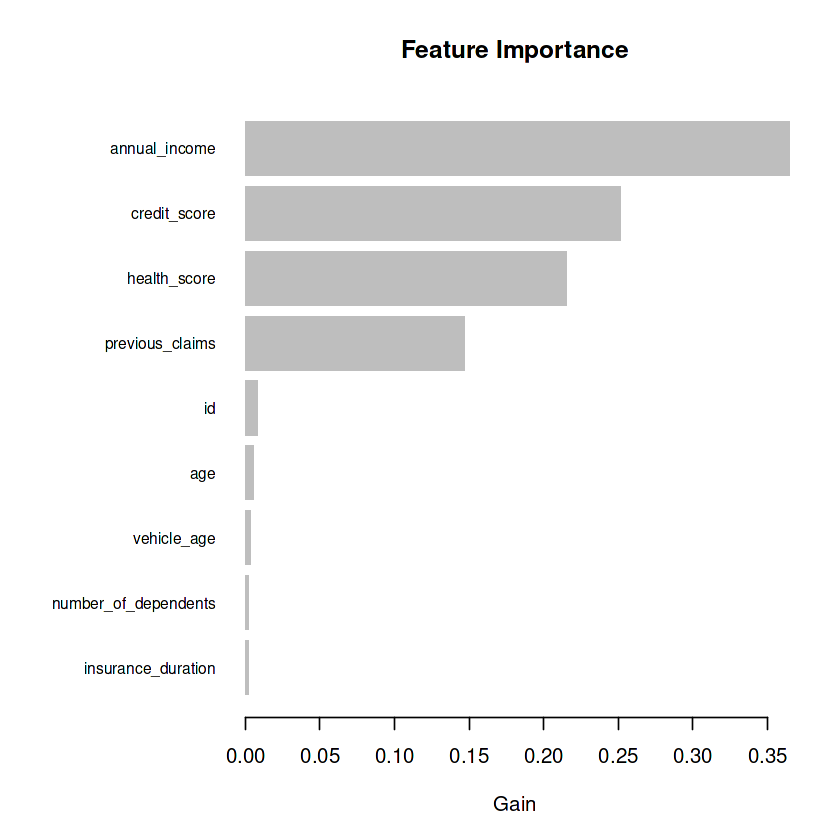

In [12]:
lgb.importance(lgb_model) %>%
  lgb.plot.importance()